## Arbeitsschritte  
<a id="Arbeitsschritte"></a>
Die Schritte, die Sie in diesem Notebook ausführen sollen, umfassen:  

1. [Analyse der Datensätze](#Analyse-daten): Sie sollen die zwei Trainingsdatensätze laden und analysieren. Was ist der Umfang der Datensätze? Wie kann die Varianz in den Datensätzen abgeschätzt werden? Wie vollständig sind die Datensätze?  
    * *Training_single_well.csv* enthält Daten eines einzelnen Bohrlochs.  
    * *Training_multiple_wells.csv* enthält Daten mehrerer Bohrlöcher. 

2. [Vorbereitung der Datensätze](#Konditionierung-daten):  Basierend auf den Ergebnissen des ersten Schritts: Müssen die Datensätze vor Weitergabe an die SVM bearbeitet werden? Müssen die Datensätze konditioniert, und oder standardisiert werden?

3. [Erstellung der SVMs](#SVM-training): Mit den im 2. Schritt bereiteten Daten sollen zwei SVMs trainiert werden (siehe Auflistung). Nutzen Sie eine Vergleichsprüfung, um die Modellparameter der SVMs (C und gamma) zu finden, welche die Klassifizierung optimieren.

    * `SVM-single` an dem bearbeiteten Datensatz *Training_single_well*  
    * `SVM-multi` an dem bearbeiteten Datensatz *Training_multiple_wells*   

4. [Anwendung der trainierten SVMs](#Blind-test): Wenn beide Klassifizierungsmethoden bestmöglich eingestellt wurden, wenden Sie sie auf Bohrlochdaten an, welche bisher keine Faziesklassifizierung haben (Datensatz *Blind_single_well.csv*).

<hr>
<center> Bitte tragen Sie in der unten stehenden Zelle Ihren Namen und Matrikelnummer ein. </center>
<hr>

In [ ]:
NAME = ""
MATNUM = ""

In [1]:
### import libraries and data, display data
### contains all necessary libraries. If you need additional libraries, import here!
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

#import seaborn as sns

### SKLEARN functions
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix

In [2]:
### Functions for plotting. You can use those for plotting Logs together with facies. 
### It will look like the example below.
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)
    
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]

# Funktion zur Errechnung der Genauigkeit einer Confusion Matrix
def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        if(conf[i][i] != 0):
            for j in adjacent_facies[i]:
                if (i < len(conf) and j < len(conf)):
                    total_correct += conf[i][j]
    return total_correct / sum(sum(conf))


In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

def display_cm(cm, labels, hide_zeros=False,
                             display_metrics=False):
    """Display confusion matrix with labels, along with
       metrics such as Recall, Precision and F1 score.
       Based on Zach Guo's print_cm gist at
       https://gist.github.com/zachguo/10296432
    """

    precision = np.diagonal(cm)/cm.sum(axis=0).astype('float')
    recall = np.diagonal(cm)/cm.sum(axis=1).astype('float')
    F1 = 2 * (precision * recall) / (precision + recall)
    
    precision[np.isnan(precision)] = 0
    recall[np.isnan(recall)] = 0
    F1[np.isnan(F1)] = 0
    
    total_precision = np.sum(precision * cm.sum(axis=1)) / cm.sum(axis=(0,1))
    total_recall = np.sum(recall * cm.sum(axis=1)) / cm.sum(axis=(0,1))
    total_F1 = np.sum(F1 * cm.sum(axis=1)) / cm.sum(axis=(0,1))
    #print total_precision
    
    columnwidth = max([len(x) for x in labels]+[5]) # 5 is value length; error:(numpy.int64 has no length???)
    empty_cell = " " * columnwidth
    # Print header
    print("    " + " Pred", end=' ')
    for label in labels: 
        print("%{0}s".format(columnwidth) % label, end=' ')
    print("%{0}s".format(columnwidth) % 'Total')
    print("    " + " True")
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=' ')
        for j in range(len(labels)): 
            cell = "%{0}d".format(columnwidth) % cm[i, j]
            if hide_zeros:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            print(cell, end=' ')
        print("%{0}d".format(columnwidth) % sum(cm[i,:]))
        
    if display_metrics:
        print()
        print("Precision", end=' ')
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % precision[j]
            print(cell, end=' ')
        print("%{0}.2f".format(columnwidth) % total_precision)
        print("   Recall", end=' ')
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % recall[j]
            print(cell, end=' ')
        print("%{0}.2f".format(columnwidth) % total_recall)
        print("       F1", end=' ')
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % F1[j]
            print(cell, end=' ')
        print("%{0}.2f".format(columnwidth) % total_F1)
    
                  
def display_adj_cm(
        cm, labels, adjacent_facies, hide_zeros=False, 
        display_metrics=False):
    """This function displays a confusion matrix that counts 
       adjacent facies as correct.
    """
    adj_cm = np.copy(cm)
    
    for i in np.arange(0,cm.shape[0]):
        for j in adjacent_facies[i]:
            adj_cm[i][i] += adj_cm[i][j]
            adj_cm[i][j] = 0.0
        
    display_cm(adj_cm, labels, hide_zeros, 
                             display_metrics)
        


![example_log](example_log.png)

## Analyse der Datensätze
<a id="Analyse-daten"></a>
In den folgenden Zellen Sollen sie die zwei Trainingsdatensätze, die zum Anlernen der `SVMs` genutzt werden sollen, in Augenschein nehmen. Die Datensätze bestehen aus Messungen von Bohrloch-logs pro Bohrloch. Möglicherweise besitzen einzelne Log Signale jedoch Artefakte oder fehlende Einträge. Sollte das der Fall sein, müssen die Datensätze vor Anwendung auf eine `SVM` entsprechend aufbereitet werden.

Die Datensätze, welche als Trainingsdaten genutzt werden sollen, heißen `Training_single_well_n.csv` und `Training_multiple_wells_n.csv`, wobei `n` eine natürliche Zahl zwischen 0 und 19 ist. Datensätze können Sie mit mehreren Methoden in Python laden, empfohlen wird jedoch die Bibliothek *pandas* zu nutzen.



### Information über die Datensätze
<a id="info_daten"></a>
Die bereitgestellten Datensätze stammen aus dem Panoma Council Grove Gas Reservoir in Southwest Kansas.
Jedes Bohrloch in den Datensätzen umfasst sieben [Einflussgrößen](https://de.wikipedia.org/wiki/Einflussgr%C3%B6%C3%9Fe_und_Zielgr%C3%B6%C3%9Fe) (Logdaten und Geologische Daten), sowie eine zugehörige Klasse (die zugehörige Fazies). 

Die sieben Einflussvariablen sind:
* Fünf bohrloch-log Signale [gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR), [resistivity logging](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10),
[photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE), [neutron-density porosity difference and average neutron-density porosity](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI and PHIND). Note, some wells do not have PE.
* Zwei, auf geologischem Wissen beruhende Variablen: *nonmarine-marine indicator (NM_M)* und *relative Position (RELPOS)*

<hr>

Neun unterschiedliche Fazies wurden aus Kernproben abgeleitet, sind aber nicht immer eindeutig. Durch Sedimentation bedingt, gehen Fazies graduell ineinander über. Dies bedeutet, dass angrenzende Fazies falsch klassifiziert worden sein können. In der nachfolgenden Tabelle sind die neun Fazies aufgelistet, zusammen mit Abkürzungen und den angrenzenden Fazies (**Beispiel**: Fazies 2 ist üblicherweise angrenzend zu Fazies 1 und 3 zu finden). 


Facies |Label| Adjacent Facies
:---| :---: |---:
**1** Nonmarine sandstone |SS| 2
**2** Nonmarine coarse siltstone  |CSiS| 1,3
**3** Nonmarine fine siltstone  |FSiS| 2
**4** Marine siltstone and shale  |SiSh| 5
**5** Mudstone (limestone) |MS| 4,6
**6** Wackestone (limestone) |WS| 5,7
**7** Dolomite |D| 6,8
**8** Packstone-grainstone (limestone) |PS| 6,7,9
**9** Phylloid-algal bafflestone (limestone) |BS| 7,8


In [4]:
### Einladen der beiden Trainingsdatensätze. training_single für den Datensatz mit einem Bohrloch

### training_multi für den Datensatz mit mehreren Bohrlöchern

data = pd.read_csv('Training_single_well_14.csv')
data_multi = pd.read_csv('Training_multiple_wells_14.csv')

data_multi.describe()
# print(data.Formation.value_counts())
data_multi.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,2413.000000,2413.000000,2413.000000,2401.000000,2413.000000,2413.000000,2413.000000,2413.000000,2413.000000
mean,4.177373,2837.811438,66.106385,0.632058,3.967627,13.615976,3.691283,1.455864,0.511325
std,2.464178,125.458635,30.060263,0.241567,5.702005,7.505260,0.859754,0.498151,0.285403
min,1.000000,2573.500000,13.280000,-0.025949,-19.900000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2743.500000,49.410000,0.480000,1.400000,8.545000,3.100000,1.000000,0.265000
50%,3.000000,2840.000000,66.000000,0.616000,4.200000,12.375000,3.500000,1.000000,0.512000
75%,6.000000,2940.000000,79.360000,0.797000,7.500000,16.660000,4.271000,2.000000,0.755000
max,9.000000,3104.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


### Categorical data types  
<a id="kategorie"></a>
Wenn wir in pandas Spalten mit `.astype('category')` benennen, wandeln wir die Daten in dieser Spalte in Kategorien um, also Variablen, die nur diskrete Werte annehmen können. Kategorien können genutzt werden, um Datensätze effizient und schnell zu analysieren. Für weitere Informationen über `categorical data types` kann die [pandas Dokumentation](https://pandas.pydata.org/pandas-docs/stable/categorical.html) helfen.  


In [5]:
# Wandeln Sie Formation und Well Name in Kategorien

data['Well Name'] = data['Well Name'].astype('category')
data['Formation'] = data['Formation'].astype('category')
data['Well Name'].unique()

data_multi['Well Name'] = data_multi['Well Name'].astype('category')
data_multi['Formation'] = data_multi['Formation'].astype('category')
data_multi['Well Name'].unique()


[SHRIMPLIN, SHANKLE, LUKE G U, CROSS H CATTLE, NEWBY, Recruit F9]
Categories (6, object): [SHRIMPLIN, SHANKLE, LUKE G U, CROSS H CATTLE, NEWBY, Recruit F9]

### Vollständigkeit
<a id="vollstaendig"></a>
Überprüfen Sie mit der nachfolgenden Zelle (beispielhaft gezeigt für den Datensatz mit mehreren Bohrlöchern) die Vollständigkeit des Datensatzes. Stimmt die Anzahl aller Einflussgrößen überein?  
**Wenn nicht, bereinigen Sie den Datensatz, indem Zeilen mit fehlenden Einträgen entfernt werden**

In [6]:
# Analysieren Sie die Datensätze und entfernen mögliche Zeilen mit NaN Werten 
# Beispiel hier erstellt mit .describe() Methode von pandas

#data.describe()

# Der Datensatz mit den Daten eines einzelnen Bohrlochs ist vollständig. Die Anzahl aller Einflussgrößen stimmt überein. 
# Betrachtet man die Countwerte (Zählwerte), haben alle Werte 415 gültige Werte.

# Dies ist eine schnelle Ansicht der statistischen Verteilung der Eingangsvariablen. 
# Betrachtet man die Zählwerte, haben die meisten Werte 2413 gültige Werte mit Ausnahme von ILD_log10, das 2401 hat. 
# In diesem Projekt werden die Merkmalsvektoren gelöscht, die keinen gültigen ILD_log10-Eintrag haben.

### Alle Einträge wegwerfen bzw. löschen, wo kein gültiger ILD_log10-Wert ist. Daher sollte die Anzahl von 2413 auf 2401 
### reduziert werden.

# Reinigung des Datensatzes mit mehreren Bohrlöchern:

data = data.drop(data[data.DeltaPHI == 0].index)
# data.describe()

ILD_log10_mask = data_multi['ILD_log10'].notnull().values
data_multi = data_multi[ILD_log10_mask]
data_multi = data_multi.drop(data_multi[data_multi.DeltaPHI == 0].index)

data_multi.describe()


,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000,2396.000000
mean,4.175292,2837.898164,66.092402,0.631982,3.967937,13.613318,3.689873,1.456177,0.511125
std,2.463121,125.558120,30.040614,0.241603,5.709580,7.503301,0.853348,0.498180,0.285278
min,1.000000,2573.500000,13.280000,-0.025949,-19.900000,0.550000,0.646000,1.000000,0.010000
25%,2.000000,2743.375000,49.437750,0.480000,1.400000,8.545000,3.100000,1.000000,0.265000
50%,3.000000,2840.000000,65.983000,0.616000,4.200000,12.372500,3.500000,1.000000,0.510500
75%,6.000000,2940.500000,79.340000,0.797000,7.500000,16.661250,4.253750,2.000000,0.755000
max,9.000000,3104.500000,361.150000,1.480000,18.600000,84.400000,7.652000,2.000000,1.000000


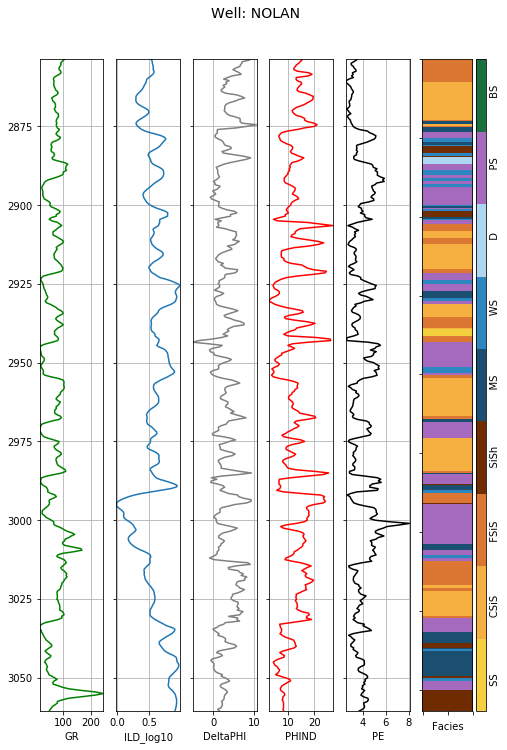

In [7]:
make_facies_log_plot(
    data[data['Well Name'] == 'NOLAN'],
    facies_colors)
plt.savefig('NOLAN_single_well.png')

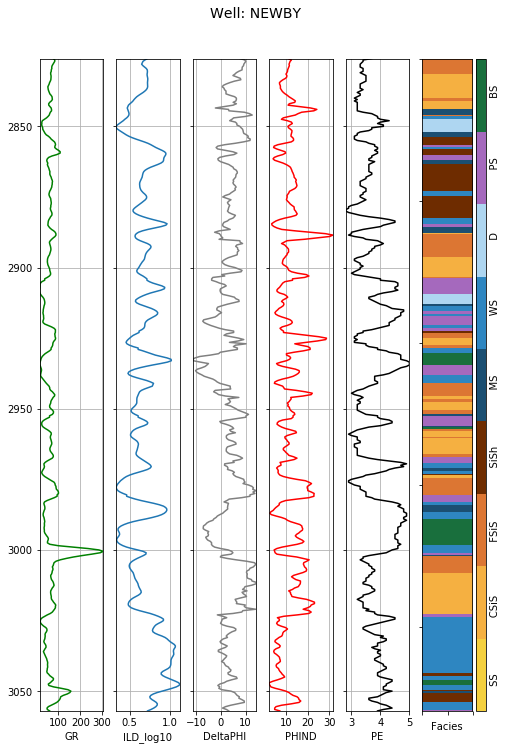

In [8]:
make_facies_log_plot(
    data_multi[data_multi['Well Name'] == 'NEWBY'],
    facies_colors)
plt.savefig('NEWBY_multiple_well.png')

Überprüfen Sie außerdem, wie die einzelnen Fazies in den jeweiligen Datensätzen vertreten sind (z.B. durch Histogramme).  
* Sind Fazies unterrepräsentiert oder gar nicht erst vorhanden? 
* Welche Auswirkungen kann dies für die `SVMs` haben?

Wie aussagekräftig sind die einzelnen Einflussgrößen? Das heißt, wie variieren sie mit der jeweiligen Fazies? 
Für diese Analyse können sie crossplots nutzen, in denen Sie zwei Logsignale gegeneinander plotten und die Datenpunkte als zugehörige Fazies einfärben. 
<hr>
Eine Möglichkeit dazu bietet beispielsweise die Visualisierungsbibliothek [seaborn](https://stanford.edu/~mwaskom/software/seaborn/) mit der Funktion [`pairplot`](https://seaborn.pydata.org/generated/seaborn.pairplot.html).

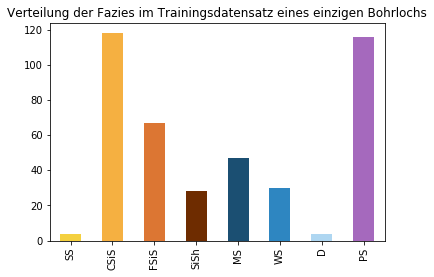

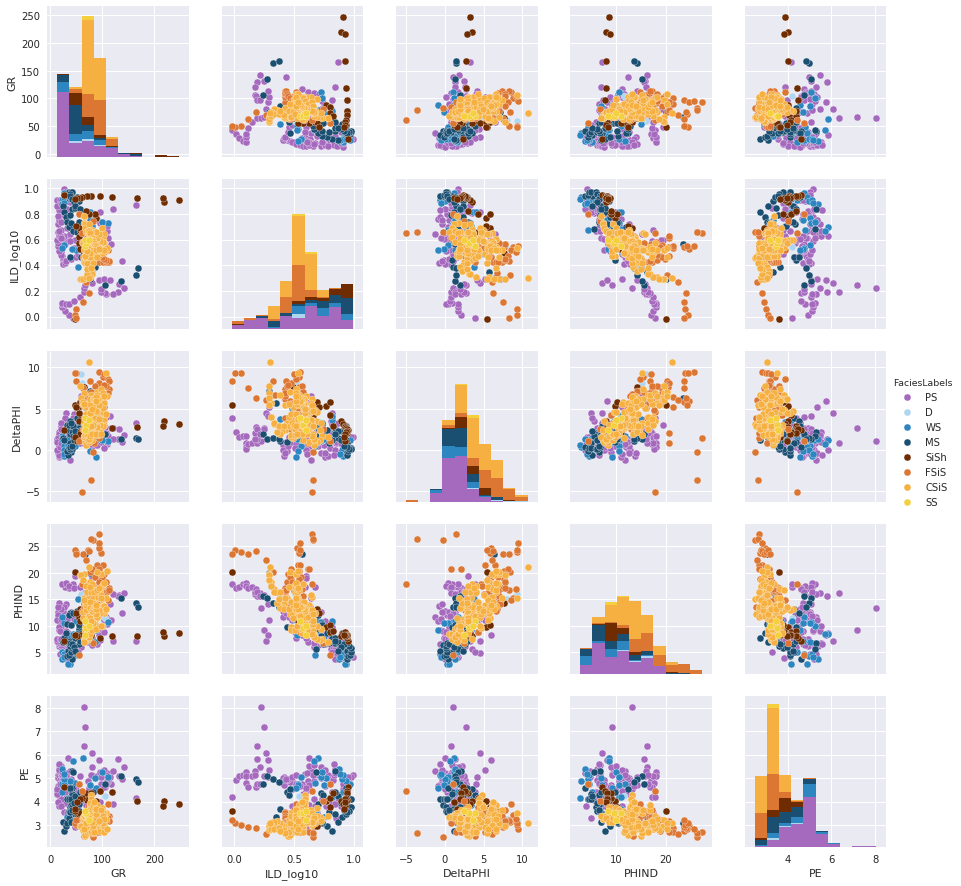

In [9]:
# Nutzen Sie Histogramme um zu überprüfen wie gut Fazies in den Datensätzen repräsentiert werden.

#facies number (instead of by number of entries)
df = data[['Facies', 'FaciesLabels']]
df = df.drop_duplicates()
df = df.sort_values(by=['Facies'])
df = df.set_index('Facies')
df
facies_labels = []
for i in range(df.shape[0]):
    facies_labels += [df['FaciesLabels'].values[i]]
facies_counts = data['Facies'].value_counts().sort_index()
facies_counts.index = facies_labels
facies_counts.index
facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Verteilung der Fazies im Trainingsdatensatz eines einzigen Bohrlochs')


plt.savefig('single_well_distribution.png')

# facies_counts

#save plot display settings to change back to when done plotting with seaborn
inline_rc = dict(mpl.rcParams)

import seaborn as sns
sns.set()
sns.pairplot(data.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))

# #switch back to default matplotlib plot style
mpl.rcParams.update(inline_rc)
plt.savefig('crossplot_single')


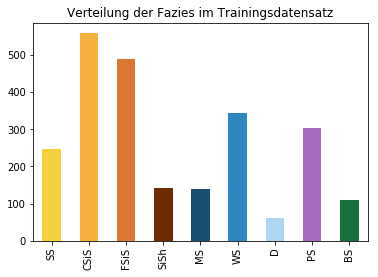

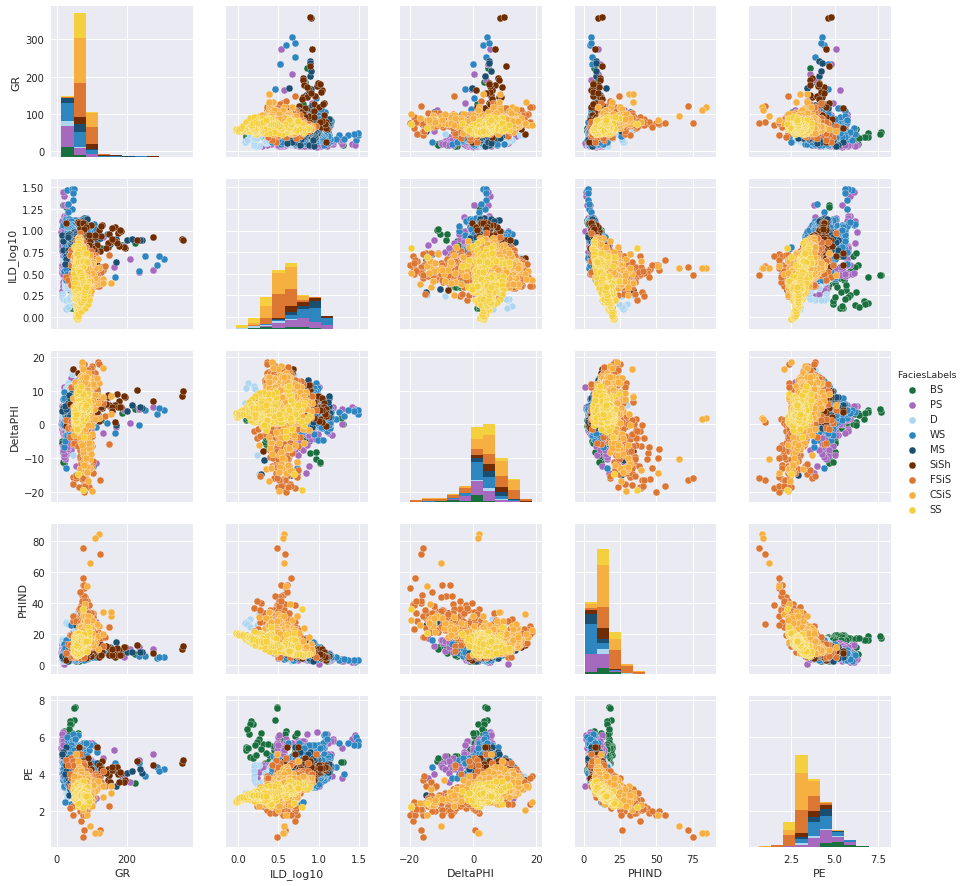

In [10]:
# Nutzen Sie Histogramme um zu überprüfen wie gut Fazies in den Datensätzen repräsentiert werden.

#facies number (instead of by number of entries)
df_multi = data_multi[['Facies', 'FaciesLabels']]
df_multi = df_multi.drop_duplicates()
df_multi = df_multi.sort_values(by=['Facies'])
df_multi = df_multi.set_index('Facies')
df_multi
facies_labels_multi = []
for i in range(df_multi.shape[0]):
    facies_labels_multi += [df_multi['FaciesLabels'].values[i]]
facies_counts_multi = data_multi['Facies'].value_counts().sort_index()
facies_counts_multi.index = facies_labels_multi
facies_counts_multi.index
facies_counts_multi.plot(kind='bar',color=facies_colors, 
                   title='Verteilung der Fazies im Trainingsdatensatz')

# facies_counts

#save plot display settings to change back to when done plotting with seaborn
inline_rc_multi = dict(mpl.rcParams)

import seaborn as sns
sns.set()
sns.pairplot(data_multi.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels_multi)))

# #switch back to default matplotlib plot style
mpl.rcParams.update(inline_rc_multi)


## Vorbereitung der Datensätze
<a id="Konditionierung-daten"></a>
In den Datensätzen sind Informationen, welche für die `SVMs` übeflüssig sind. Was benötigt wird sind nur die sieben Einflussvariablen (oder *features*), welche die charakteristischen Log-Daten und geologische Variablen für eine bestimmte Fazies sind.  
Eine Fazies sollte im Idealfall also eindeutig aus der Kombination bestimmter Logwerte und geologischer Variablen identifizierbar sein.  
<hr>
Konditionieren Sie ihre Datensätze, indem Sie nur die benötigten *feature Vektoren* behalten. Speichern Sie die korrekten Faziesbenennungen als einen eigenen Vektor zur späteren Überprüfung. 
Müssen die verwendeten Datensätze [standardisiert](https://de.wikipedia.org/wiki/Standardisierung_(Statistik)) werden? Wenn ja, warum? Standardisieren Sie die Datensätze falls nötig.

In [11]:
 
    
# Erstellen Sie die feature-Vektoren (löschen der überflüssigen Spalten)

##features = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']
#feature_vectors = data[features]

# store the correctly stored facies
#correct_facies_labels = data['Facies'].values
##correct_facies_labels

###features_multi = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']
####feature_vectors_multi = data_multi[features_multi]

# store the correctly stored facies
#####correct_facies_labels_multi = data_multi['Facies'].values
######correct_facies_labels_multi
# feature_vectors
    
    
#X_train, X_test, y_train, y_test = train_test_split(
       # feature_vectors, correct_facies_labels, test_size=0.10, random_state=42)

#########X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
       ####### feature_vectors_multi, correct_facies_labels_multi, test_size=0.10, random_state=42)
########

# import the svm and create a classifier from the SVC() method            
##########clf = svm.SVC()

# Now we can train the classifier using the training set we created above
###########clf.fit(X_train,y_train)

#predicted_labels = clf.predict(X_test)




# import the svm and create a classifier from the SVC() method            
#clf_multi = svm.SVC()

# Now we can train the classifier using the training set we created above
#clf_multi.fit(X_train_multi,y_train_multi)

#predicted_labels_multi = clf_multi.predict(X_test_multi)


####print('Genauigkeit des Trainingsdatensatzes eines einzelnen Bohrloches vor dem Skalieren = {:2f}'.format(clf.score(X_train, y_train)))
###print('Genauigkeit des Testdatensatzes eines einzelnen Bohrloches vordem Skalieren = {:2f}'.format(clf.score(X_test, y_test)))
##print('Genauigkeit des Trainingsdatensatzes mehrerer Bohrlöcher vor dem Skalieren  = {:2f}'.format(clf_multi.score(X_train_multi, y_train_multi)))
#print('Genauigkeit des Testdatensatzes mehrerer Bohrlöcher vor dem Skalieren = {:2f}'.format(clf_multi.score(X_test_multi, y_test_multi)))

In [12]:
# Speichern Sie die korrekte Fazies spalte in einem neuen Dataframe
# Erstellen Sie die feature-Vektoren (löschen der überflüssigen Spalten)

features = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']
feature_vectors = data[features]

# store the correctly stored facies
correct_facies_labels = data['Facies'].values
correct_facies_labels

features_multi = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']
feature_vectors_multi = data_multi[features_multi]

# store the correctly stored facies
correct_facies_labels_multi = data_multi['Facies'].values
correct_facies_labels_multi
# feature_vectors
correct_facies_labels

array([2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 5, 5, 2, 3,
       5, 5, 5, 8, 8, 8, 8, 6, 6, 5, 5, 6, 4, 4, 4, 4, 6, 6, 4, 7, 7, 7,
       7, 8, 8, 8, 8, 6, 6, 6, 8, 8, 6, 6, 8, 8, 6, 6, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 6, 5, 8, 6, 4, 4, 4, 4, 5, 6, 8, 8, 3, 3, 3, 3, 3,
       2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 8, 8, 8, 8, 8, 6, 6, 8, 8, 8, 8, 8, 5, 5, 5, 5, 6, 6,
       8, 8, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 1, 1, 1, 1,
       3, 3, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 6, 6,
       6, 6, 8, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 3, 5, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 5,
       8, 8, 8, 8, 8, 8, 4, 5, 5, 5, 6, 6, 3, 3, 3, 3, 3, 3, 4, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,

In [13]:
# standardisierung / Skalierung falls notwendig. Tipp: Siehe sklearn.preprocessing.StandardScaler().fit(...)

scaler = preprocessing.StandardScaler().fit(feature_vectors)
scaled_features = scaler.transform(feature_vectors)

# now the feature vectors are standardized 
# print(scaled_features)
scaled_features_df = pd.DataFrame(scaled_features, index=feature_vectors.index, columns=feature_vectors.columns)
scaled_features_df

scaler_multi = preprocessing.StandardScaler().fit(feature_vectors_multi)
scaled_features_multi = scaler_multi.transform(feature_vectors_multi)

# now the feature vectors are standardized 
# print(scaled_features)
scaled_features_df_multi = pd.DataFrame(scaled_features_multi, index=feature_vectors_multi.index, columns=feature_vectors_multi.columns)
scaled_features_df_multi

,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,0.378154,0.132550,1.039184,-0.226390,1.066760,-0.915879,1.714035
1,0.405123,0.120130,1.792461,-0.139743,0.480710,-0.915879,1.640408
2,0.431426,0.107711,1.897569,-0.075092,-0.105340,-0.915879,1.563274
3,0.666157,0.095291,1.739907,-0.066427,-0.222550,-0.915879,1.489646
4,0.282596,0.062172,1.669834,-0.041766,-0.339760,-0.915879,1.416018
...,...,...,...,...,...,...,...
2408,3.967378,0.819772,-0.085477,-0.748936,0.260355,1.091848,-1.206529
2409,5.207625,0.910850,0.113178,-0.887037,-0.155740,1.091848,-1.266132
2410,0.263285,0.563099,-0.652537,-0.525654,2.323251,1.091848,-1.090828
2411,-1.591358,2.740682,-0.655340,-1.441442,1.137086,1.091848,1.545743


Da wir über keine weiteren Testdaten verfügen, nutzen Sie die Methode [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) von Scikit, um Ihre Trainingsdatensätze in **Trainingsdaten** und **Testdaten** zu unterteilen.
Nutzen Sie zwischen 10 % und 20 % der Trainingsdaten für Testzwecke. Welchen Einfluss hat der Prozentsatz der Testdaten auf die Ergebnisse/Qualität der `SVM`?

In [14]:
# trennen in Trainingsdaten und Testdaten

X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, correct_facies_labels, test_size=0.15, random_state=42)

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
        scaled_features_multi, correct_facies_labels_multi, test_size=0.15, random_state=42)


## Erstellung der SVM Klassifizierer
<a id="SVM-training"></a>
Die bereinigten Trainingsdatensätze sollen nun genutzt werden, um `SVMs` anzulernen. SVMs in [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) können mit einer Menge an Eingabeparametern eingestellt werden. 

In [15]:
# for data
# Erstellen der SVMs und diese an Trainingsdaten trainieren und an Testdaten testen

# import the svm and create a classifier from the SVC() method            
clf = svm.SVC()

# Now we can train the classifier using the training set we created above
clf.fit(X_train,y_train)

predicted_labels = clf.predict(X_test)


# import the svm and create a classifier from the SVC() method            
clf_multi = svm.SVC()

# Now we can train the classifier using the training set we created above
clf_multi.fit(X_train_multi,y_train_multi)

predicted_labels_multi = clf_multi.predict(X_test_multi)


print('Genauigkeit des Trainingsdatensatzes eines einzelnen Bohrloches nach dem Skalieren = {:2f}'.format(clf.score(X_train, y_train)))
print('Genauigkeit des Testdatensatzes eines einzelnen Bohrloches nach dem Skalieren = {:2f}'.format(clf.score(X_test, y_test)))
print('Genauigkeit des Trainingsdatensatzes mehrerer Bohrlöcher nach dem Skalieren  = {:2f}'.format(clf_multi.score(X_train_multi, y_train_multi)))
print('Genauigkeit des Testdatensatzes mehrerer Bohrlöcher nach dem Skalieren = {:2f}'.format(clf_multi.score(X_test_multi, y_test_multi)))

Genauigkeit des Trainingsdatensatzes eines einzelnen Bohrloches nach dem Skalieren = 0.763533
Genauigkeit des Testdatensatzes eines einzelnen Bohrloches nach dem Skalieren = 0.634921
Genauigkeit des Trainingsdatensatzes mehrerer Bohrlöcher nach dem Skalieren  = 0.679764
Genauigkeit des Testdatensatzes mehrerer Bohrlöcher nach dem Skalieren = 0.661111


In [20]:
from sklearn.metrics import confusion_matrix
#from classification_utilities import display_cm, display_adj_cm
unique_elem = []
for elem in y_test:
    if elem not in unique_elem:
        unique_elem.append(elem)
unique_elem.sort()
unique_elem

df = data[['Facies', 'FaciesLabels']]
df = df.drop_duplicates()
df = df.sort_values(by=['Facies'])
df = df.set_index('Facies')
df
df['FaciesLabels'].values[0]
new_facies_labels = []
for elem in unique_elem:
    new_facies_labels += [df['FaciesLabels'].values[elem-1]]
# new_facies_labels
conf = confusion_matrix(y_test, predicted_labels)
# # print(conf)
display_cm(conf, new_facies_labels, hide_zeros=True)
conf
new_facies_labels

     Pred    SS  CSiS  FSiS  SiSh    MS    WS    PS Total
     True
       SS           2                                   2
     CSiS          10     3                            13
     FSiS           2     5                             7
     SiSh                       5                       5
       MS                             5           4     9
       WS                 1           1           6     8
       PS           1     1     1     1          15    19


C:\Users\Polina\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'PS']

In [17]:
from sklearn.metrics import confusion_matrix
#from classification_utilities import display_cm, display_adj_cm
unique_elem_multi = []
for elem_multi in y_test_multi:
    if elem_multi not in unique_elem_multi:
        unique_elem_multi.append(elem_multi)
unique_elem_multi.sort()
# unique_elem_multi

df_multi = data_multi[['Facies', 'FaciesLabels']]
df_multi = df_multi.drop_duplicates()
df_multi = df_multi.sort_values(by=['Facies'])
df_multi = df_multi.set_index('Facies')
df_multi
# df['FaciesLabels'].values[0]
new_facies_labels_multi = []
for elem_multi in unique_elem_multi:
    new_facies_labels_multi += [df_multi['FaciesLabels'].values[elem_multi-1]]
# new_facies_labels
conf_multi = confusion_matrix(y_test_multi, predicted_labels_multi)
# print(conf)

display_cm(conf_multi, new_facies_labels_multi, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    18    15     3                                        36
     CSiS     5    64    18                                        87
     FSiS          20    60                                        80
     SiSh                      17           6           2          25
       MS                 2     1     1    16     2     4          26
       WS                 1     3          37           6          47
        D                 1                       2     3           6
       PS                 2     2           7          25     1    37
       BS                       1           1                14    16


In [18]:
display_cm(conf, new_facies_labels, display_metrics=True, hide_zeros=True)
print()
print()
display_cm(conf_multi, new_facies_labels_multi, display_metrics=True, hide_zeros=True)

     Pred    SS  CSiS  FSiS  SiSh    MS    WS    PS Total
     True
       SS           2                                   2
     CSiS          10     3                            13
     FSiS           2     5                             7
     SiSh                       5                       5
       MS                             5           4     9
       WS                 1           1           6     8
       PS           1     1     1     1          15    19

Precision  0.00  0.67  0.50  0.83  0.71  0.00  0.60  0.54
   Recall  0.00  0.77  0.71  1.00  0.56  0.00  0.79  0.63
       F1  0.00  0.71  0.59  0.91  0.63  0.00  0.68  0.58


     Pred    SS  CSiS  FSiS  SiSh    MS    WS     D    PS    BS Total
     True
       SS    18    15     3                                        36
     CSiS     5    64    18                                        87
     FSiS          20    60                                        80
     SiSh                      17           6           2  

C:\Users\Polina\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
adjacent_facies_multi = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6], [5]])#, [5,6,8], [6,7]])

display_adj_cm(conf, new_facies_labels, adjacent_facies, display_metrics=True, hide_zeros=True)
print()
print()
display_adj_cm(conf_multi, new_facies_labels_multi, adjacent_facies_multi, display_metrics=True, hide_zeros=True)

# new_facies_labels

Bewerten Sie die Qualität der beiden Klassifizierungsalgorithmen. Nutzen Sie dazu Methoden wie eine [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/), [precision und recall](https://en.wikipedia.org/wiki/Precision_and_recall), bzw den [F1-Score](https://en.wikipedia.org/wiki/Precision_and_recall#F-measure). 

Die confusion matrix ist eine Tabelle, die dafür genutzt werden kann direkt abzuschätzen wie viele Fazies die `SVMs` richtig identifiziert haben. Die Hauptdiagonale der Matrix spiegelt die Anzahl der richtig vorhergesagten und tatsächlich richtigen Fazies wider. [Scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) ermöglicht schnelle und unkomplizierte Erstellung solch einer Matrix.  

Precision ist ein Maß, welches abschätzt wie oft ein Wert *X* richtig vorausgesagt wurde. $Pr = \frac{True\, positives}{predicted\, true}$
<hr>
*Recall* beschreibt das Verhältnis von richtig positiven Klassifizierungen zu tatsächlich positiven. $RL = \frac{True\, positives}{actual\, true}$

Nutzen Sie die funktionen `accuracy` und `accuracy_adjacent`, um die Genauigkeit der `SVMs` zu berechnen. Beachten Sie, dass bei der `SVM`, die nur auf Daten eines Bohrlochs beruht, womöglich nicht alle Fazies im Bohrloch vertreten sind. Dementsprechend muss der array `adjacent_facies` bearbeitet werden.

In [ ]:
# Erstellen Sie arrays für die benachbarten Fazies für beide Datensätze (siehe Tabelle oben). 
# ACHTUNG: Fehlt eine Fazies in einem der Datensätze, muss der Array natürlich entsprechend angeglichen werden
# Funktion zur Errechnung der Genauigkeit einer Confusion Matrix


In [ ]:
print('Facies classification accuracy = %f' % accuracy(conf))
print('Adjacent facies classification accuracy = %f' % accuracy_adjacent(conf, adjacent_facies))

print()

print('Facies classification accuracy multi = %f' % accuracy(conf_multi))
print('Adjacent facies classification accuracy multi= %f' % accuracy_adjacent(conf_multi, adjacent_facies_multi))

## Einstellen der SVM
<a id="einstellen_SVM"></a> 
Nutzen Sie eine Vergleichsprüfung, um zwei dieser Parameter, `C` und `gamma` optimal einzustellen. 
Der Parameter `C` beeinflusst, wie viele falsche Klassifizierungen in den Trainingsdatensätzen die `SVM` zulässt. Ein großer Wert wird versuchen, Fehlklassifizierungen zu vermeiden. Wird der Wert aber zu groß abgeschätzt, wird die `SVM` nicht mehr allgemein anwendbar (Stichwort: *overfitting*). `gamma` ist ein Koeffizient der verwendeten Kernelfunktion, welcher die Entfernung zwischen zwei Vektoren *bewertet*.

Kann die Performance der `SVM` durch die Wahl eines anderen `kernels` verbessert werden?  
(Standard der `svm` Funktion ist der ([radial basis function `rbf` kernel (the default)](https://en.wikipedia.org/wiki/Radial_basis_function_kernel))  
Wie verändert sich die Performance der SVMs mit optimierten `C` und `gamma` gegenüber den *default*-Werten (wenn weder `C` noch `gamma` in der Funktion spezifiziert werden)? 


Wie ändert sich die Performance der SVM, wenn auch Klassifizierungen als richtig gewertet werden, bei denen Eine Fazies als benachbarte Fazies klassifizier wird? 
Beispiel Fazies 2:  
Facies |Label| Adjacent Facies
:---| :---: |---:
**2** Nonmarine coarse siltstone  |CSiS| 1,3  

Ohne Betrachtung der 3. Spalte würden **nur** Fazies 2 Klassifizierungen der SVM als richtig gewertet werden, die tatsächlich Fazies 2 sind. Berücksichtigt man die benachbarten Fazies, würden auch Fazies 1 oder 3 Klassifizierungen der SVM als richtig gelten, wenn eigentlich Fazies 2 vorliegt.


In [ ]:
# Vergleichsprüfung mit verschiedenen Werten von C und gamma
C_range = np.array([.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000])
gamma_range = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])


#model selection takes a few minutes, change this variable
#to true to run the parameter loop
do_model_selection = True

if do_model_selection:
    C_range = np.array([.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000])
    gamma_range = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])
    
    fig, axes = plt.subplots(3, 2, 
                        sharex='col', sharey='row',figsize=(10,10))
    plot_number = 0
    for outer_ind, gamma_value in enumerate(gamma_range):
        row = int(plot_number / 2)
        column = int(plot_number % 2)
        cv_errors = np.zeros(C_range.shape)
        train_errors = np.zeros(C_range.shape)
        for index, c_value in enumerate(C_range):
            
            clf = svm.SVC(C=c_value, gamma=gamma_value)
            clf.fit(X_train,y_train)
            
            train_conf = confusion_matrix(y_train, clf.predict(X_train))
            cv_conf = confusion_matrix(y_test, clf.predict(X_test))
        
            cv_errors[index] = accuracy(cv_conf)
            train_errors[index] = accuracy(train_conf)

        ax = axes[row, column]
        ax.set_title('Gamma = %g'%gamma_value)
        ax.semilogx(C_range, cv_errors, label='CV error')
        ax.semilogx(C_range, train_errors, label='Train error')
        plot_number += 1
        ax.set_ylim([0.2,1.2])
        
    ax.legend(bbox_to_anchor=(1.05, -0.5), loc='lower right', borderaxespad=0.)
    fig.text(0.5, 0.03, 'C value', ha='center',
             fontsize=18)
             
    fig.text(0.04, 0.5, 'Genauigkeit der Klassifikation des Datensatzes mit einem enzelnen Bohrloch', va='center', 
             rotation='vertical', fontsize=14)
    plt.savefig('Model_single_well.png')   

In [ ]:
# Vergleichsprüfung mit verschiedenen Werten von C und gamma
C_range = np.array([.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000])
gamma_range = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])


#model selection takes a few minutes, change this variable
#to true to run the parameter loop
do_model_selection = True

if do_model_selection:
    C_range = np.array([.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000])
    gamma_range = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10])
    
    fig, axes = plt.subplots(3, 2, 
                        sharex='col', sharey='row',figsize=(10,10))
    plot_number = 0
    for outer_ind, gamma_value in enumerate(gamma_range):
        row = int(plot_number / 2)
        column = int(plot_number % 2)
        cv_errors = np.zeros(C_range.shape)
        train_errors = np.zeros(C_range.shape)
        for index, c_value in enumerate(C_range):
            
            clf_multi = svm.SVC(C=c_value, gamma=gamma_value)
            clf_multi.fit(X_train_multi,y_train_multi)
            
            train_conf = confusion_matrix(y_train_multi, clf_multi.predict(X_train_multi))
            cv_conf = confusion_matrix(y_test_multi, clf_multi.predict(X_test_multi))
        
            cv_errors[index] = accuracy(cv_conf)
            train_errors[index] = accuracy(train_conf)

        ax = axes[row, column]
        ax.set_title('Gamma = %g'%gamma_value)
        ax.semilogx(C_range, cv_errors, label='CV error')
        ax.semilogx(C_range, train_errors, label='Train error')
        plot_number += 1
        ax.set_ylim([0.2,1.2])
        
    ax.legend(bbox_to_anchor=(1.05, -0.5), loc='lower right', borderaxespad=0.)
    fig.text(0.5, 0.03, 'C value', ha='center',
             fontsize=18)
             
    fig.text(0.04, 0.5, 'Genauigkeit der Klassifikation des Datensatzes mit mehreren Bohrlöchern', va='center', 
             rotation='vertical', fontsize=14)
    plt.savefig('Model_multi_well.png')   

In [ ]:
# Trainieren der beiden SVMs mit optimierten Parametern C und gamma

clf = svm.SVC(C=20, gamma=0.1)        
clf.fit(X_train, y_train)

cv_conf = confusion_matrix(y_test, clf.predict(X_test))


# Trainieren der beiden SVMs mit optimierten Parametern C und gamma
   
clf_multi = svm.SVC(C=5, gamma=1)        
clf_multi.fit(X_train_multi, y_train_multi)

cv_conf_multi = confusion_matrix(y_test_multi, clf_multi.predict(X_test_multi))

print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf, adjacent_facies))
print('Optimized facies classification accuracy = %.2f' % accuracy(cv_conf_multi))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(cv_conf_multi, adjacent_facies_multi))


In [ ]:
# Confusion Matrizen beider Datensätze mit und ohne benachbarte Fazies
display_cm(cv_conf, new_facies_labels, 
           display_metrics=True, hide_zeros=True)
print()
print()
display_cm(cv_conf_multi, new_facies_labels_multi, 
           display_metrics=True, hide_zeros=True)

In [ ]:
# Confusion Matrizen beider Datensätze mit und ohne benachbarte Fazies
# Confusion Matrizen beider Datensätze mit und ohne benachbarte Fazies

adjacent_facies_multi = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6], [5]])#, [5,6,8], [6,7]])

display_adj_cm(conf, new_facies_labels, adjacent_facies,display_metrics=True, hide_zeros=True)
print()
print()
display_adj_cm(conf_multi, new_facies_labels_multi, adjacent_facies_multi,display_metrics=True, hide_zeros=True)

# new_facies_labels

In [ ]:
y_pred = clf.predict(scaled_features)
data['Prediction'] = y_pred

compare_facies_plot(data,'Prediction', facies_colors)
plt.savefig('1_fazies_single_well_nach.png')   

In [ ]:
y_pred_multi = clf_multi.predict(scaled_features_multi)
data_multi['Prediction'] = y_pred_multi

compare_facies_plot(data_multi,'Prediction', facies_colors)
plt.savefig('2_fazies_multi_well_nach.png')   

## Anwendung der SVM Modelle auf einen Blind-Datensatz
<a id="Blind-test"></a>
Neben den zwei Trainingsdatensätzen haben Sie eine csv Datei mit dem Namen `Blind_single_well_n.csv` erhalten (`n` sollte die gleiche Zahl sein wie bei den Trainingsdatensätzen!). Analog zu den Schritten mit den Trainingsdatensätzen müssen Sie den Blind-Datensatz vorbereiten, einen *feature Vektor* erstellen und die Vorhersagen durch die beiden `SVMs` als neue Spalten dem Blind-Datensatzes hinzufügen.   
Der Blind-Datensatz enthält eine Faziesklassifizierung (`Facies`), die Sie nutzen können, um die Vorhersagen der beiden `SVMs` nicht nur untereinander zu vergleichen, sondern auch gegenüber der wirklichen Fazieseinteilung. 

In [ ]:
# Einladen des Blinddatensatzes
data_blind = pd.read_csv('Blind_single_well_14.csv')

The label vector is just the `Facies` column:

In [ ]:
# Vorbereiten des Blinddatensatzes (Erstellen Feature Vektor, Standardisieren der Daten etc)

# Wandeln Sie Formation und Well Name in Kategorien
data_blind['Well Name'] = data_blind['Well Name'].astype('category')
data_blind['Formation'] = data_blind['Formation'].astype('category')
data_blind['Well Name'].unique()


In [ ]:
# Reinigung des Datensatzes
data_blind = data_blind.drop(data_blind[data_blind.DeltaPHI == 0].index)
data_blind.describe()

In [ ]:
# Nutzen Sie Histogramme um zu überprüfen wie gut Fazies in den Datensätzen repräsentiert werden.

#facies number (instead of by number of entries)
df_blind = data_blind[['Facies', 'FaciesLabels']]
df_blind = df_blind.drop_duplicates()
df_blind= df_blind.sort_values(by=['Facies'])
df_blind = df_blind.set_index('Facies')
df_blind
facies_labels = []
for i in range(df_blind.shape[0]):
    facies_labels += [df_blind['FaciesLabels'].values[i]]
facies_counts = data_blind['Facies'].value_counts().sort_index()
facies_counts.index = facies_labels
facies_counts.index
facies_counts.plot(kind='bar',color=facies_colors, 
                   title='Distribution of Blind Data by Facies')
# facies_counts

#save plot display settings to change back to when done plotting with seaborn
inline_rc = dict(mpl.rcParams)

import seaborn as sns
sns.set()
sns.pairplot(data_blind.drop(['Well Name','Facies','Formation','Depth','NM_M','RELPOS'],axis=1),
             hue='FaciesLabels', palette=facies_color_map,
             hue_order=list(reversed(facies_labels)))

# #switch back to default matplotlib plot style
mpl.rcParams.update(inline_rc)

In [ ]:
# Speichern Sie die korrekte Fazies spalte in einem neuen Dataframe
# Erstellen Sie die feature-Vektoren (löschen der überflüssigen Spalten)

features_blind = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']
feature_vectors_blind = data_blind[features_blind]

# store the correctly stored facies
correct_facies_labels_blind = data_blind['Facies'].values
correct_facies_labels_blind

In [ ]:
# standardisierung / Skalierung falls notwendig. Tipp: Siehe sklearn.preprocessing.StandardScaler().fit(...)

scaler_blind = preprocessing.StandardScaler().fit(feature_vectors_blind)
scaled_features_blind = scaler_blind.transform(feature_vectors_blind)

# now the feature vectors are standardized 
# print(scaled_features)
scaled_features_df_blind_simple = pd.DataFrame(scaled_features_blind, index=feature_vectors_blind.index, columns=feature_vectors_blind.columns)
scaled_features_df_blind_simple

In [ ]:
# Evaluieren durch die SVMs

# Trainieren der beiden SVMs mit optimierten Parametern C und gamma
#data_blind = data_blind.drop('Prediction_multi', 1)

y_pred_blind = clf.predict(scaled_features_blind)
data_blind['Prediction_single'] = y_pred_blind

y_pred_blind_multi = clf_multi.predict(scaled_features_blind)
data_blind['Prediction_multi'] = y_pred_blind_multi
#data_blind = data_blind.drop('Prediction_multi', 1)
# data_blind['Prediction_multi'] = y_pred_blind_multi
data_blind
# compare_facies_plot(data_blind,'Prediction', facies_colors)



In [ ]:
# Blind w/o adjacent facies - Multiple wells trained

In [ ]:
# Confusion Matrizen und Vergleichsplots für das Blindbohrloch (ähnlich zu oben. 

# Confusion Matrizen beider Datensätze mit und ohne benachbarte Fazies
# Siehe Routine: compare_facies_plot)
from sklearn.metrics import confusion_matrix
#from classification_utilities import display_cm, display_adj_cm
unique_elem_blind = []
for elem in correct_facies_labels_blind:
    if elem not in unique_elem_blind:
        unique_elem_blind.append(elem)
unique_elem_blind.sort()
unique_elem_blind

df_blind = data_blind[['Facies', 'FaciesLabels']]
df_blind = df_blind.drop_duplicates()
df_blind = df_blind.sort_values(by=['Facies'])
df_blind = df_blind.set_index('Facies')
df_blind
df_blind['FaciesLabels'].values[0]
new_facies_labels_blind = []
for elem in unique_elem_blind:
    new_facies_labels_blind += [df_blind['FaciesLabels'].values[elem-1]]

# new_facies_labels_blind
conf_blind = confusion_matrix(correct_facies_labels_blind, y_pred_blind)
display_cm(conf_blind, new_facies_labels_blind, 
           display_metrics=True, hide_zeros=True)
print()
print()
conf_blind_multi = confusion_matrix(correct_facies_labels_blind, y_pred_blind_multi)
display_cm(conf_blind_multi, new_facies_labels_blind, 
           display_metrics=True, hide_zeros=True)

adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

correct_facies_labels_blind
new_facies_labels_blind
facies_labels
conf_blind_multi


In [ ]:
# adjacent_facies_multi = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])

#single model with neighboars
display_adj_cm(conf_blind, new_facies_labels_blind, adjacent_facies,display_metrics=True, hide_zeros=True)
print()
print()
#multi model with neighboars
display_adj_cm(conf_blind_multi, new_facies_labels_blind, adjacent_facies, display_metrics=True, hide_zeros=True)


In [ ]:
new_facies_labels_blind

In [ ]:
#for single model
#single model w\out neighboars
display_cm(conf_blind, new_facies_labels_blind, 
           display_metrics=True, hide_zeros=True)
print()
#single model with neighboars
display_adj_cm(conf_blind, new_facies_labels_blind, adjacent_facies, display_metrics=True, hide_zeros=True)


print()
print('Optimized facies classification accuracy = %.2f' % accuracy(conf_blind))
print('Optimized adjacent facies classification accuracy = %.2f' % accuracy_adjacent(conf_blind, adjacent_facies))
print()
print()
print('Optimized facies classification accuracy multi = %.2f' % accuracy(conf_blind_multi))
print('Optimized adjacent facies classification accuracy multi = %.2f' % accuracy_adjacent(conf_blind_multi, adjacent_facies))


In [ ]:
#for multi model
#multi model w\out neighboars
display_cm(conf_blind_multi, new_facies_labels_blind, 
           display_metrics=True, hide_zeros=True)
print()
#multi model with neighboars
display_adj_cm(conf_blind_multi, new_facies_labels_blind, adjacent_facies,display_metrics=True, hide_zeros=True)


In [ ]:
compare_facies_plot(data_blind,'Prediction_single', facies_colors)
plt.savefig('1_pred_single_blind.png')   

In [ ]:
compare_facies_plot(data_blind,'Prediction_multi', facies_colors)
plt.savefig('2_pred_multi_blind.png')   